In [1]:
import numpy as np 
import pandas as pd
import torch 
from bokeh.models import ColumnDataSource

import sys
import os
import pickle 
current_path = notebook_dir = os.getcwd()
working_dir = os.path.abspath(os.path.join(current_path, '..','..'))
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)

from constants.paths import FOLDER_PATH

## Get NetMob consumption around station 

In [2]:
from load_inputs.netmob_POIs_per_station import extract_apps_tags_modes
stations = ['AMP', 'BLA', 'BRO', 'COR', 'CRO', 'CUS', 'FLA', 'GAR', 'GIL', 'GRA', 'HEN', 'JAU', 'LAE', 'MAC', 'MER', 'PAR', 'PRY', 'SAN', 'SOI', 'VEN',
            'BEL', 'BON', 'CHA', 'CPA', 'CUI', 'DEB', 'FOC', 'GER', 'GOR', 'GUI', 'HOT', 'JEA', 'LUM', 'MAS', 'OGA', 'PER', 'REP', 'SAX', 'VAI', 'VMY']
Apps = ['Instagram', 'Deezer','Web_Weather','Web_Downloads','Google_Maps','Twitter','Tor','Microsoft_Office']


NetMob_selected_tags = ['station_epsilon300'] # 'station_epislon300'
data_dict_eps300 = {station_i:{app_j : {} for app_j in Apps} for station_i in stations}
for station_i in stations:
    for app_j in Apps:
        path_epsilon_around_station = f'POIs/netmob_POI_Lyon/InputsEpsilon/{station_i}'
        data_path,metadata_path = f'{FOLDER_PATH}/{path_epsilon_around_station}/data.npy', f'{FOLDER_PATH}/{path_epsilon_around_station}/metadata.pkl'  #contains 68 apps
        data_app = np.load(open(data_path,"rb"))
        metadata = pickle.load(open(metadata_path,"rb"))

        NetMob_selected_apps = [app_j]
        NetMob_transfer_mode = ['DL']
        data = extract_apps_tags_modes(data_app,metadata,NetMob_selected_apps,NetMob_selected_tags,NetMob_transfer_mode)
        data_dict_eps300[station_i][app_j] = data.reshape(-1)
if False:
    pickle.dump(data_dict,open('NetMob_samples_epsilon300.pkl','wb'))

## Down META du 11 Mai

/tmp/ipykernel_269299/1880594254.py:6: RuntimeWarning: divide by zero encountered in log
  pd.DataFrame(np.log(data_dict_eps300[station_i]['Instagram']),index = coverage_local).plot(title = 'Consumption Instagram in log scale')


<Axes: title={'center': 'Consumption Instagram in log scale'}>

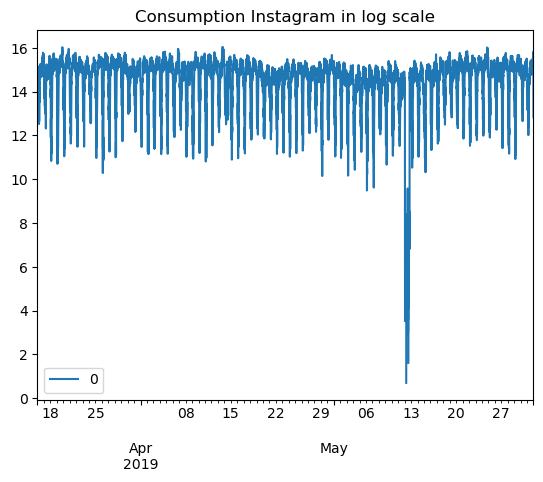

In [14]:
START = '03/16/2019'
END = '06/01/2019'
FREQ = '15min'
coverage_local = pd.date_range(start=START, end=END, freq=FREQ)[:-1]

pd.DataFrame(np.log(data_dict_eps300[station_i]['Instagram']),index = coverage_local).plot(title = 'Consumption Instagram in log scale')

/root/anaconda3/envs/tuning_rochas/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


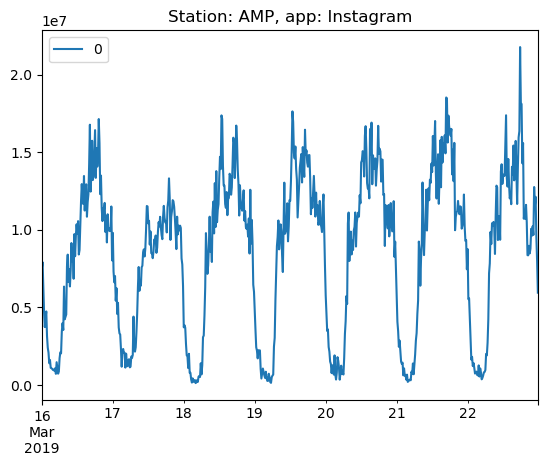

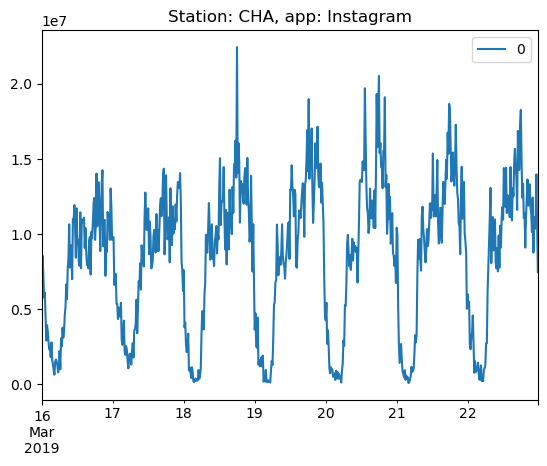

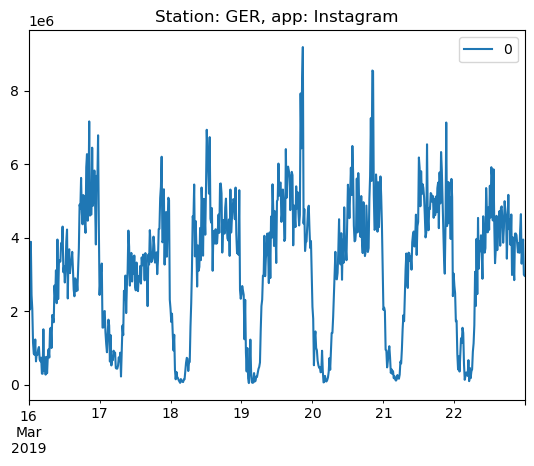

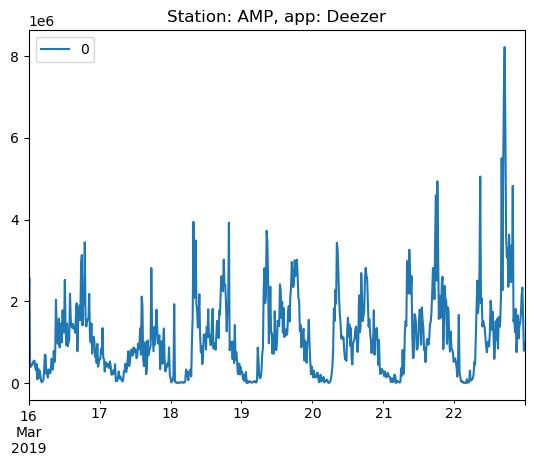

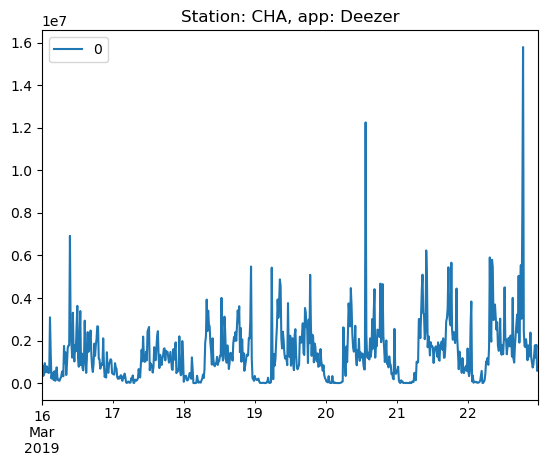

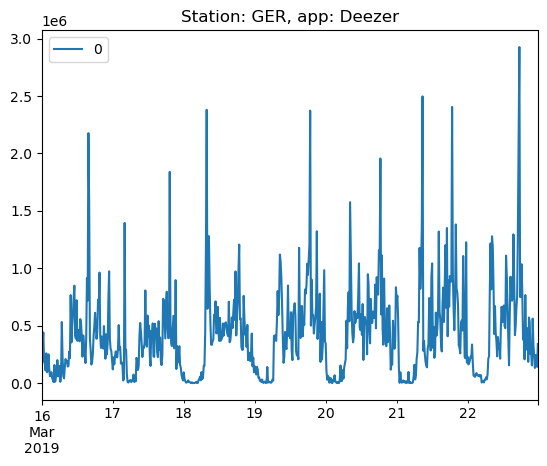

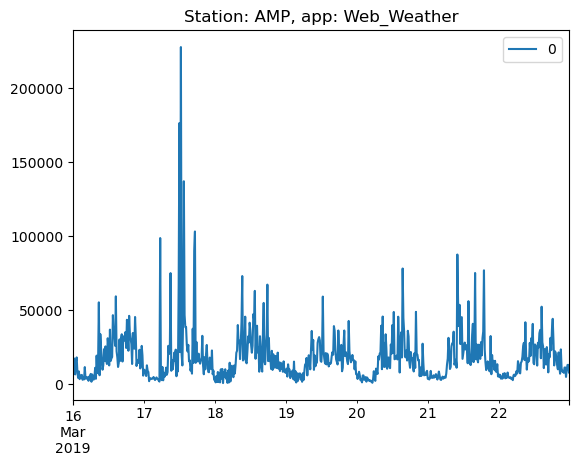

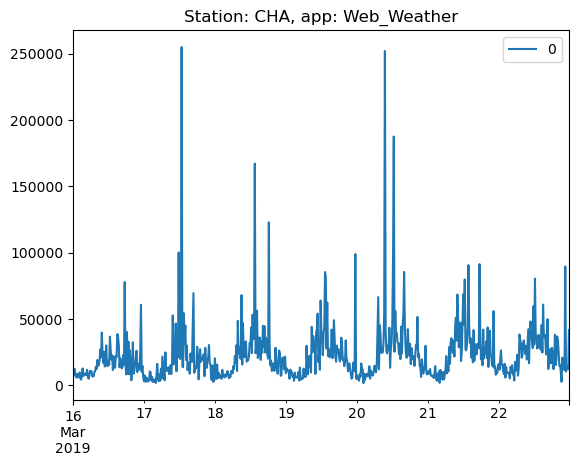

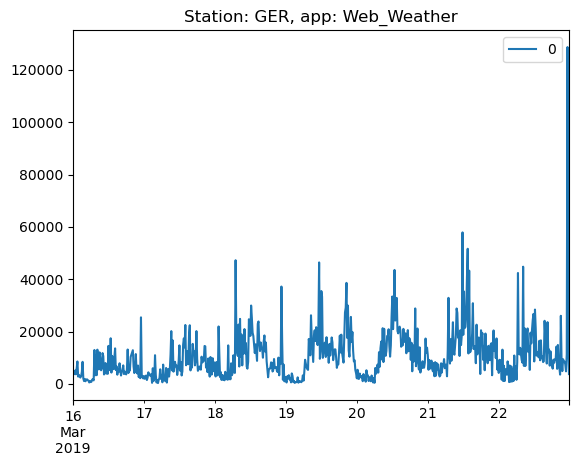

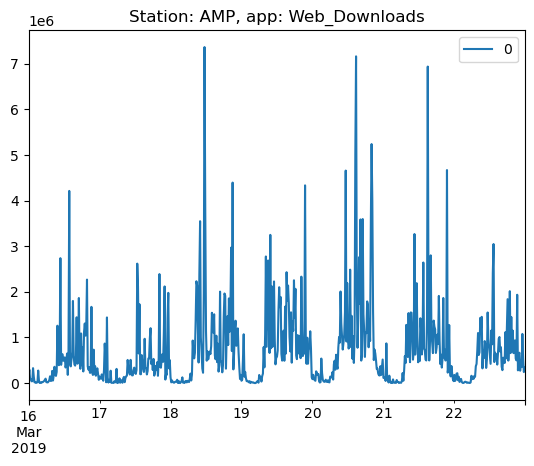

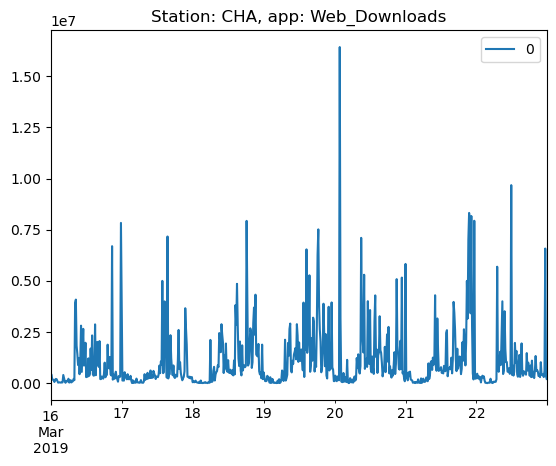

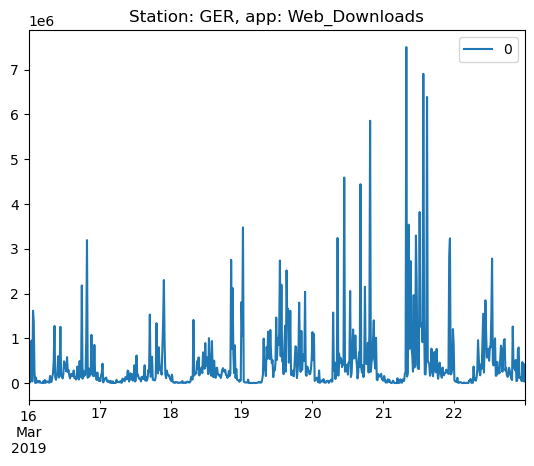

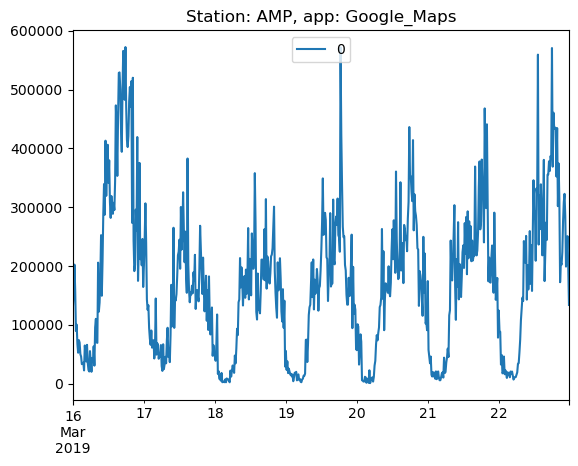

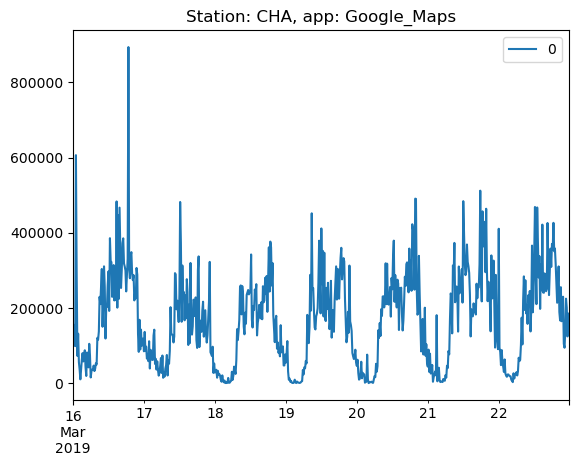

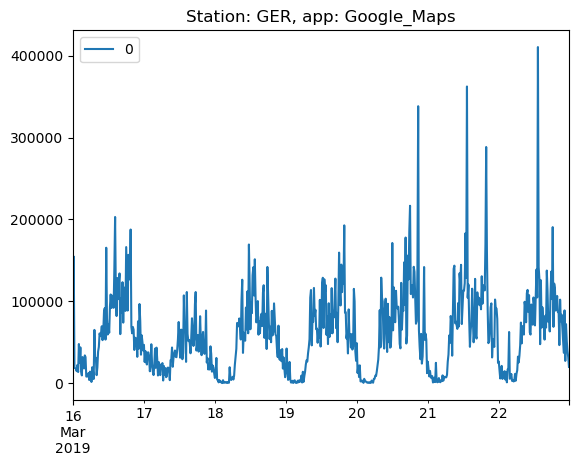

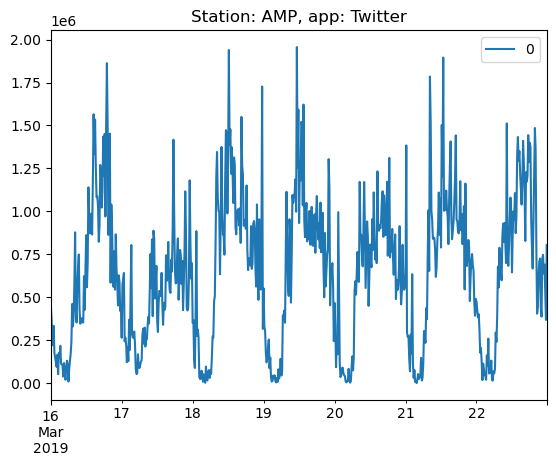

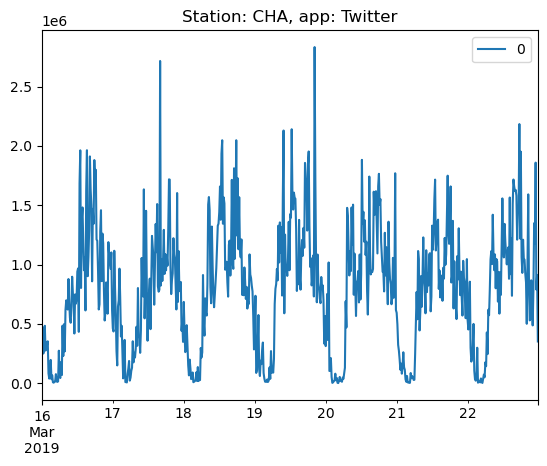

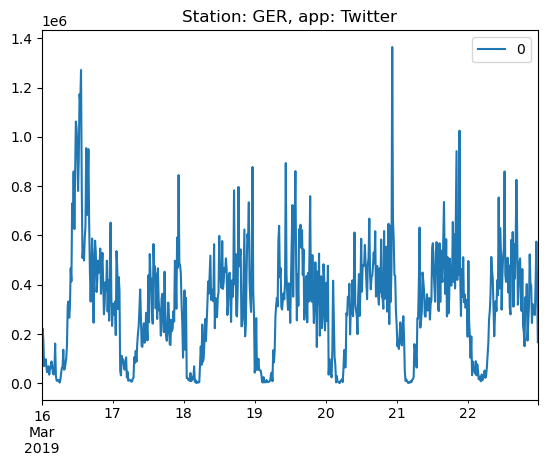

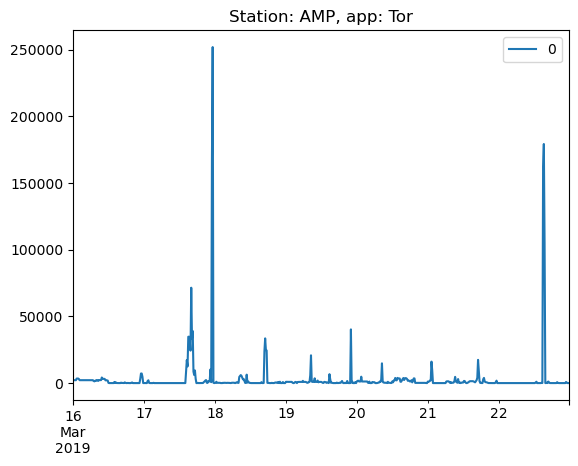

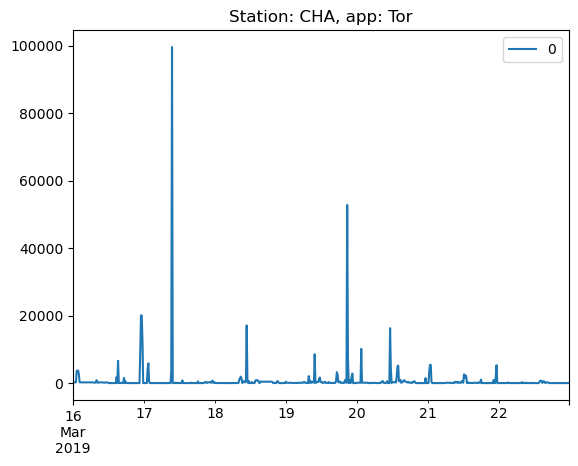

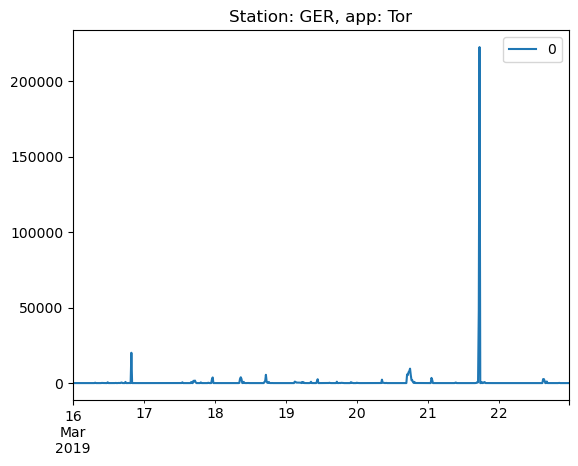

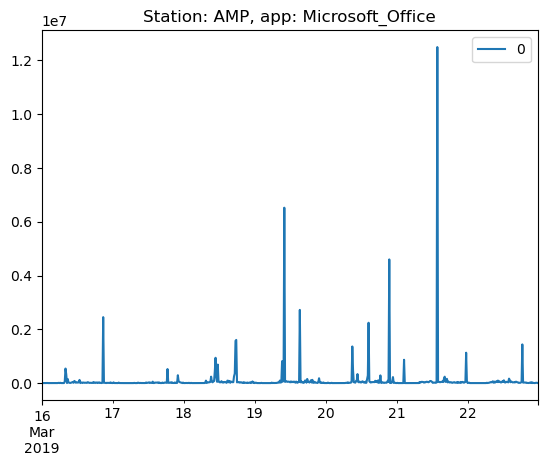

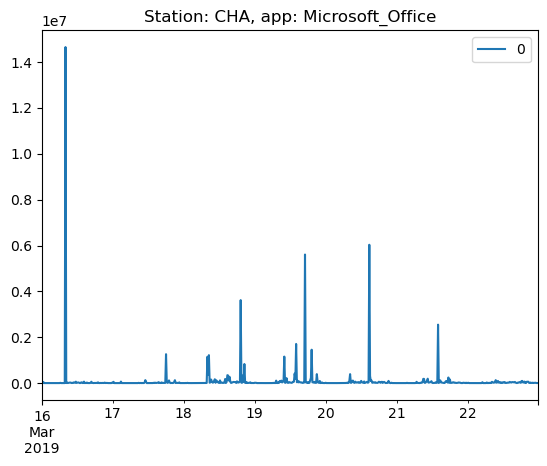

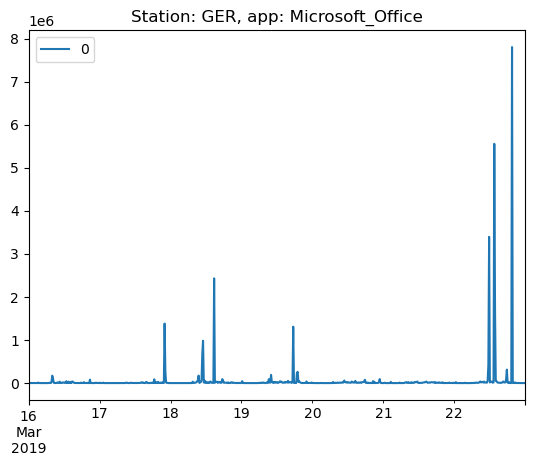

In [15]:
#data_dict_eps300 = pickle.load(open('NetMob_samples_epsilon300.pkl','rb'))
#data_dict_eps100 = pickle.load(open('NetMob_samples_epsilon100.pkl','rb'))

stations = ['AMP', 'BLA', 'BRO', 'COR', 'CRO', 'CUS', 'FLA', 'GAR', 'GIL', 'GRA', 'HEN', 'JAU', 'LAE', 'MAC', 'MER', 'PAR', 'PRY', 'SAN', 'SOI', 'VEN',
            'BEL', 'BON', 'CHA', 'CPA', 'CUI', 'DEB', 'FOC', 'GER', 'GOR', 'GUI', 'HOT', 'JEA', 'LUM', 'MAS', 'OGA', 'PER', 'REP', 'SAX', 'VAI', 'VMY']
Apps = ['Instagram', 'Deezer','Web_Weather','Web_Downloads','Google_Maps','Twitter','Tor','Microsoft_Office']

for app_j in Apps:
    for station_i in ['AMP','CHA','GER']:
        pd.DataFrame(data_dict_eps300[station_i][app_j],index = coverage_local).iloc[:96*7].plot(title = f"Station: {station_i}, app: {app_j}")

## Get Netmob from POIs:
Légèrement différent. Nécessite d'avoir accès en parallèle à un geopandas pour savoir de quel OSMID on parle:

In [ ]:
# POIs:
POI_types = ['iris','nightclub','park','parkings','public_transport','shop','stadium','station','theatre','transit','university']
Apps = ['Facebook','Google','Instagram','LinkedIn','Messenger','Snapchat','Twitter','WhatsApp']
POI_type = POI_types[0]
app_j = Apps[0]
transfer_mode = 'DL'

In [ ]:
# Aggregated data: 
path_agg_POI = f'POIs/netmob_POI_Lyon/Inputs/agg_TS/{POI_type}/{station_i}/{transfer_mode}'
data_path_agg,metadata_path_agg = f'{path_agg_POI}/data.npy', f'{path_agg_POI}/metadata.pkl' #Contains TS from all osmid of the same POI type

In [ ]:
# Time Series of POIs data: 
path_POI = f'POIs/netmob_POI_Lyon/Inputs/{station_i}'
data_path,metadata_path = f'{path_POI}/data.npy', f'{path_POI}/metadata.pkl' #contains 68 apps, all POIs

In [ ]:
## Time series data
f'POIs/netmob_POI_Lyon/{POI_type}/{app_j}/df_{osmid}_{transfer_mode}.csv'